In [1]:
import time

from keras.models import Sequential
from keras.layers import Dense

import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer

#Counts number of repetitions of elements in a list
from collections import Counter

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#Imports utils. A customed module. 

#### Download the data from url as zip and store it and load it. If it is already downloaded then just load it. 

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

def download_and_read_text():

    if not isfile(dataset_filename):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
            urlretrieve(
                'http://mattmahoney.net/dc/text8.zip',
                dataset_filename,
                pbar.hook)

    if not isdir(dataset_folder_path):
        with zipfile.ZipFile(dataset_filename) as zip_ref:
            zip_ref.extractall(dataset_folder_path)
            
    with open('data/text8') as f:
        text = f.read()


    return text



In [3]:
def fit_tokenizer(cleaned_text_list, oov_token = '<OOV>', num_words = None):
    #This function is just to eliminate the training of the Tokenizer object. Big drawbacks
    #we cannot change hyperparams.

    tokenizer = Tokenizer(oov_token = oov_token, num_words = num_words)
    tokenizer.fit_on_texts(cleaned_text_list)

    return tokenizer

#### SkipGram word pairing functions.

In [4]:
def skipgram_single_word_pair(text_list, index, window_size = 5):
    
    num_words = len(text_list)

    rand_window = np.random.randint(1, window_size +1)

    start_index = (index - rand_window) if (index - rand_window) > 0 else 0 

    end_index = (index + rand_window) if (index + rand_window) < num_words else num_words - 1

    word_list = set(text_list[start_index : index] + text_list[index + 1 : end_index])
    
    pairs = [(text_list[index], word) for word in word_list]

    return pairs

In [5]:
def cbow_single_word_pair(text_list, index, window_size = 5):
    
    num_words = len(text_list)

    rand_window = np.random.randint(1, window_size +1)

    start_index = (index - rand_window) if (index - rand_window) > 0 else 0 

    end_index = (index + rand_window) if (index + rand_window) < num_words else num_words - 1

    word_list = set(text_list[start_index : index] + text_list[index + 1 : end_index])
    
    pairs = [(word, text_list[index]) for word in word_list]

    return pairs

The following function would be better as a generator to help save space. Further adjustments. 

In [6]:
def word_pair_texts(text_list, single_pairing_function, window_size = 5):

    word_pairs = []

    for word_index in tqdm(range(len(text_list))):

        word_pairs += single_pairing_function(text_list, word_index, window_size = window_size)

    word_pairs = np.array(word_pairs)

    return word_pairs

#### Graphing

In [7]:
def graph_errors(training_history):
    
    acc = training_history.history['accuracy']
    val_loss = training_history.history['val_loss']
    val_acc = training_history.history['val_accuracy']
    loss = training_history.history['loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
    plt.title('Training accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

This has has to have a better approach with the object. The idea is just to define the structure. 

#### Model classes.

This could be generalized to a single model type function and then just change the incoming data. 

In [27]:
class SkipGram(Sequential):

    def __init__(self, input_shape, num_classes, embedding_dims):
        super().__init__()
        self.add(Dense(embedding_dims, activation = 'linear', input_shape = input_shape))
        self.add(Dense(num_classes, activation = 'softmax', name = 'output_layer'))

        self.preprocessing_function = skipgram_single_word_pair

    def word_pair_texts(self, text_list, window_size = 5):

        word_pairs = []

        for word_index in tqdm(range(len(text_list))):

            word_pairs += self.preprocessing_function(text_list, word_index, window_size = window_size)

        word_pairs = np.array(word_pairs)



        return word_pairs


class CBOW(Sequential):

    def __init__(self, input_shape, num_classes, embedding_dims):
        super().__init__()
        self.add(Dense(embedding_dims, activation = 'linear', input_shape = input_shape))
        self.add(Dense(num_classes, activation = 'softmax', name = 'output_layer'))



    

class MyTokenizer(Tokenizer):

    def __init__(self, num_words = None):
        super().__init__(num_words = num_words)

    def clean_text(self, text_string, min_num_appearances = 5):
    # Replace punctuation with tokens so we can use them in our model
        text = text_string.lower()
        text = text.replace('.', ' <PERIOD> ')
        text = text.replace(',', ' <COMMA> ')
        text = text.replace('"', ' <QUOTATION_MARK> ')
        text = text.replace(';', ' <SEMICOLON> ')
        text = text.replace('!', ' <EXCLAMATION_MARK> ')
        text = text.replace('?', ' <QUESTION_MARK> ')
        text = text.replace('(', ' <LEFT_PAREN> ')
        text = text.replace(')', ' <RIGHT_PAREN> ')
        text = text.replace('--', ' <HYPHENS> ')
        text = text.replace('?', ' <QUESTION_MARK> ')
        # text = text.replace('\n', ' <NEW_LINE> ')
        text = text.replace(':', ' <COLON> ')
        words = text.split()
        
        # Remove all words with  5 or fewer occurences
        word_counts = Counter(words)
        
        trimmed_words = [word for word in tqdm(words) if word_counts[word] > min_num_appearances]

        return trimmed_words
    


    def skipgram_word_pairing(self, text_list, window_size = 5):

        word_pairs = []

        for word_index in tqdm(range(len(text_list))):

            word_pairs += skipgram_single_word_pair(text_list, word_index, window_size)

        word_pairs = np.array(word_pairs)

        return word_pairs


    def cbow_word_pairing(self, text_list, window_size):

        word_pairs = []

        for word_index in tqdm(range(len(text_list))):

            word_pairs += cbow_single_word_pair(text_list, word_index, window_size)

        word_pairs = np.array(word_pairs)

        return_word_pairs


#### Download text

In [9]:
text = download_and_read_text()

## Data preprocessing

#### Cleaning text

#### Obtain word pairs

#### Tokenizer

In [28]:
num_words = 1000

tokenizer = MyTokenizer(num_words = num_words)

cleaned_text = tokenizer.clean_text(text)

cleaned_subsample = cleaned_text[:20000]

fitted_tokenizer = tokenizer.fit_on_texts(cleaned_text)

100%|██████████| 17005207/17005207 [00:19<00:00, 857496.04it/s] 


#### Skipgram data preprocessing

In [29]:
skipgram_word_pairs = tokenizer.skipgram_word_pairing(cleaned_subsample)



100%|██████████| 20000/20000 [00:00<00:00, 50938.16it/s]


In [31]:
display(skipgram_word_pairs.shape)

X_skipgram_vec = tokenizer.


(96910, 2)

(97003, 2)

#### CBOW data preprocessing

In [ ]:
cbow_word_pairs = tokenizer.skipgram_word_pairing(cleaned_subsample)

In [ ]:
display(cbow_word_pairs.shape)

Transform words to vectors.

In [25]:
X_vec = tokenizer.texts_to_matrix()

y_vec = tokenizer.texts_to_matrix(y)

NameError: name 'X' is not defined

In [57]:
display(X_vec[:3])
display(X_vec.shape)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(58838, 1000)

## Model


In [58]:
num_words = fitted_tokenizer.num_words

In [59]:
display(num_words)

1000

#### Create model and holder.

In [60]:
skipgram = SkipGram((num_words,), num_words, 300)

In [61]:

display(skipgram)

In [62]:
skipgram.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [63]:
print(skipgram.summary())

Model: "skip_gram_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 300)               300300    
                                                                 
 output_layer (Dense)        (None, 1000)              301000    
                                                                 
Total params: 601,300
Trainable params: 601,300
Non-trainable params: 0
_________________________________________________________________
None


#### Fiting model

In [64]:
history = skipgram.fit(X_vec, y_vec, validation_split = .2 ,epochs = 10, verbose = 1, batch_size = 5)

Epoch 1/10
9414/9414 [==============================] - 210s 22ms/step - loss: 5.1181 - accuracy: 0.1960 - val_loss: 5.2818 - val_accuracy: 0.2594
Epoch 2/10
9414/9414 [==============================] - 198s 21ms/step - loss: 4.7356 - accuracy: 0.1969 - val_loss: 5.4825 - val_accuracy: 0.2492
Epoch 3/10
9414/9414 [==============================] - 192s 20ms/step - loss: 4.4937 - accuracy: 0.1957 - val_loss: 5.5716 - val_accuracy: 0.2450
Epoch 4/10
9414/9414 [==============================] - 200s 21ms/step - loss: 4.3472 - accuracy: 0.1937 - val_loss: 5.5557 - val_accuracy: 0.2469
Epoch 5/10
9414/9414 [==============================] - 132s 14ms/step - loss: 4.2692 - accuracy: 0.1909 - val_loss: 5.5992 - val_accuracy: 0.2367
Epoch 6/10
9414/9414 [==============================] - 124s 13ms/step - loss: 4.2329 - accuracy: 0.1897 - val_loss: 5.6073 - val_accuracy: 0.2379
Epoch 7/10
9414/9414 [==============================] - 121s 13ms/step - loss: 4.2146 - accuracy: 0.1890 - val_loss: 5

#### Updating holder with fitted_model

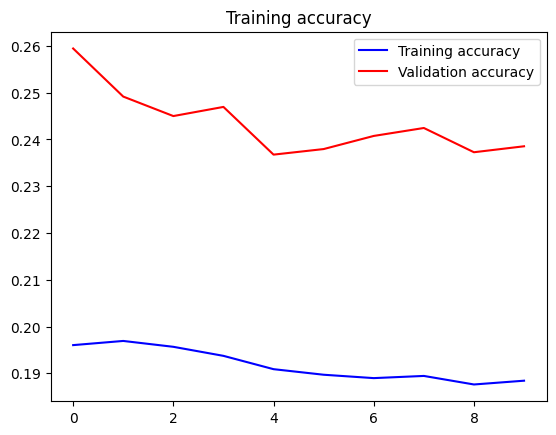

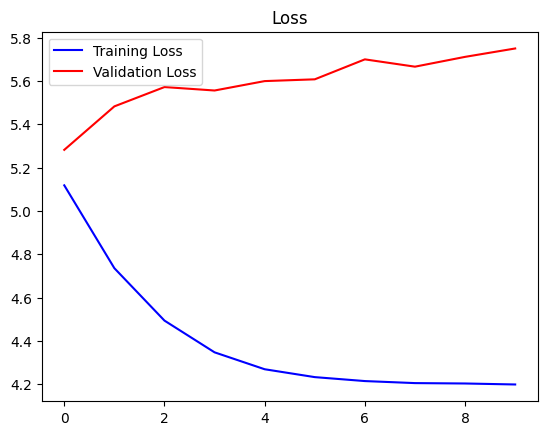

In [65]:
graph_errors(history)

## Model Evaluation

### We want to access the parameters of the projection layer. 
 retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape (vocab_size, embedding_dimension)

In [66]:
def cut_dict(n_words):

    aux_dict = {}

    for key, items in fitted_tokenizer.word_index.items():

        if items <= n_words:

            aux_dict[key] = items

In [67]:
def write_projector_files(word_index, embedding_matrix):

    out_v = open('vecs.tsv', 'w')
    out_m = open('meta.tsv', 'w')
    for word, i in word_index.items():
        vec = embedding_matrix[:, i-1]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_v.close()
    out_m.close()

In [68]:
#word_index = fitted_tokenizer.word_index

#small_word_index = cut_dict(300)

In [69]:
#embedding_matrix = skipgram.layers[0].get_weights()[0]

In [70]:
#write_projector_files(word_index, embedding_matrix)